# Analyse Comportementale Clientèle Retail - Exploration et Préparation des Données

Ce notebook Jupyter (`notebooks/exploration.ipynb`) est dédié à la phase d'exploration et de préparation des données pour le projet d'analyse comportementale clientèle retail. Nous analyserons la qualité du dataset (valeurs manquantes, aberrantes, corrélations), corrigerons les problèmes identifiés, et préparerons les données pour les étapes suivantes (préprocessing avancé, modélisation).

Le dataset contient 52 features issues de transactions réelles d'une entreprise e-commerce de cadeaux. L'objectif est de nettoyer et explorer les données pour améliorer la qualité avant la modélisation.

## Imports et Configuration

Nous importons les bibliothèques nécessaires pour l'analyse de données, la visualisation et le preprocessing.

In [23]:
# Imports des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

# Configuration pour les visualisations
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

## Chargement des Données

Chargeons le dataset brut depuis le dossier `data/raw/`. Assurez-vous que le fichier est présent (ex. : `customer_behavior_data.csv`).

In [24]:
# Chemin vers le dataset brut
data_path = '../data/raw/retail_customers_COMPLETE_CATEGORICAL.csv'

# Chargement du dataset
df = pd.read_csv(data_path)

# Aperçu des premières lignes
print("Aperçu du dataset :")
print(df.head())

# Informations générales sur le dataset
print("\nInformations sur le dataset :")
print(df.info())

# Statistiques descriptives
print("\nStatistiques descriptives :")
print(df.describe())

Aperçu du dataset :
   CustomerID  Recency  Frequency  MonetaryTotal  MonetaryAvg  MonetaryStd  \
0       17850      302         35        5288.63    16.950737    13.603662   
1       13047       32         18        3079.10    15.709694    11.684769   
2       12583        3         18        7187.34    28.634821    23.150132   
3       13748       96          5         948.25    33.866071    42.953119   
4       15100      330          6         635.10   105.850000   215.986263   

   MonetaryMin  MonetaryMax  TotalQuantity  AvgQuantityPerTransaction  ...  \
0       -30.60       107.25           1693                   5.426282  ...   
1       -15.00        68.00           1355                   6.913265  ...   
2       -60.84       132.80           5009                  19.956175  ...   
3         9.36       204.00            439                  15.678571  ...   
4      -131.40       350.40             58                   9.666667  ...   

                Region  LoyaltyLevel  Chur

## Analyse de la Qualité des Données

### 1. Valeurs Manquantes

Analysons la présence de valeurs manquantes dans le dataset.

Pourcentage de valeurs manquantes par colonne :
AvgDaysBetweenPurchases     1.806953
Age                        29.986276
dtype: float64


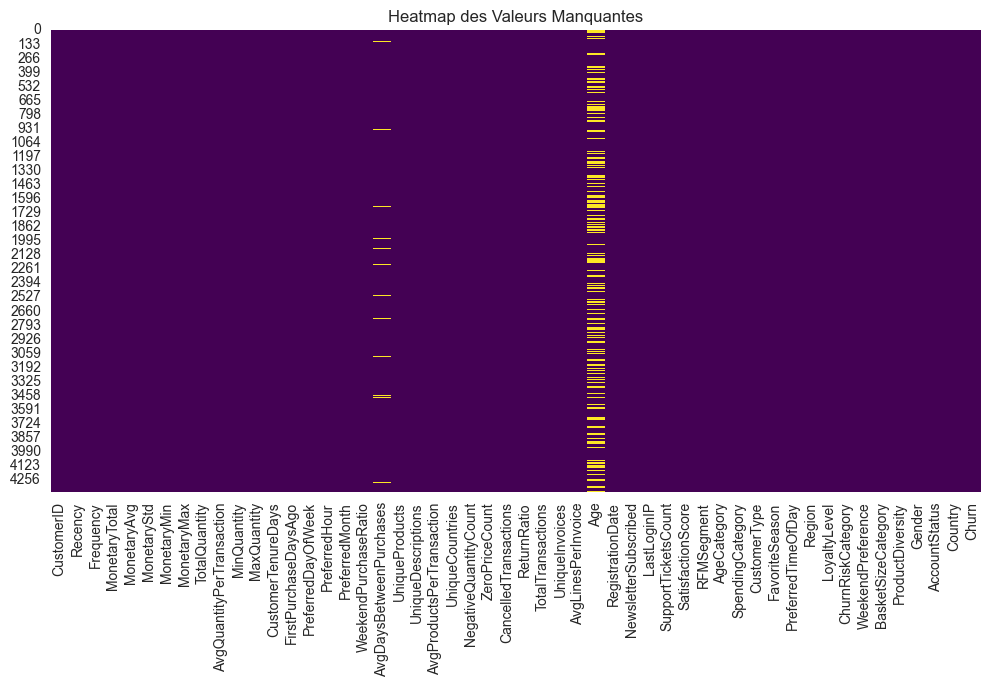

In [25]:
# Pourcentage de valeurs manquantes par colonne
missing_values = df.isnull().sum() / len(df) * 100
print("Pourcentage de valeurs manquantes par colonne :")
print(missing_values[missing_values > 0])

# Visualisation des valeurs manquantes
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap des Valeurs Manquantes')
plt.show()

### 2. Valeurs Aberrantes (Outliers)

Détectons les outliers à l'aide de boxplots et de méthodes statistiques (IQR).

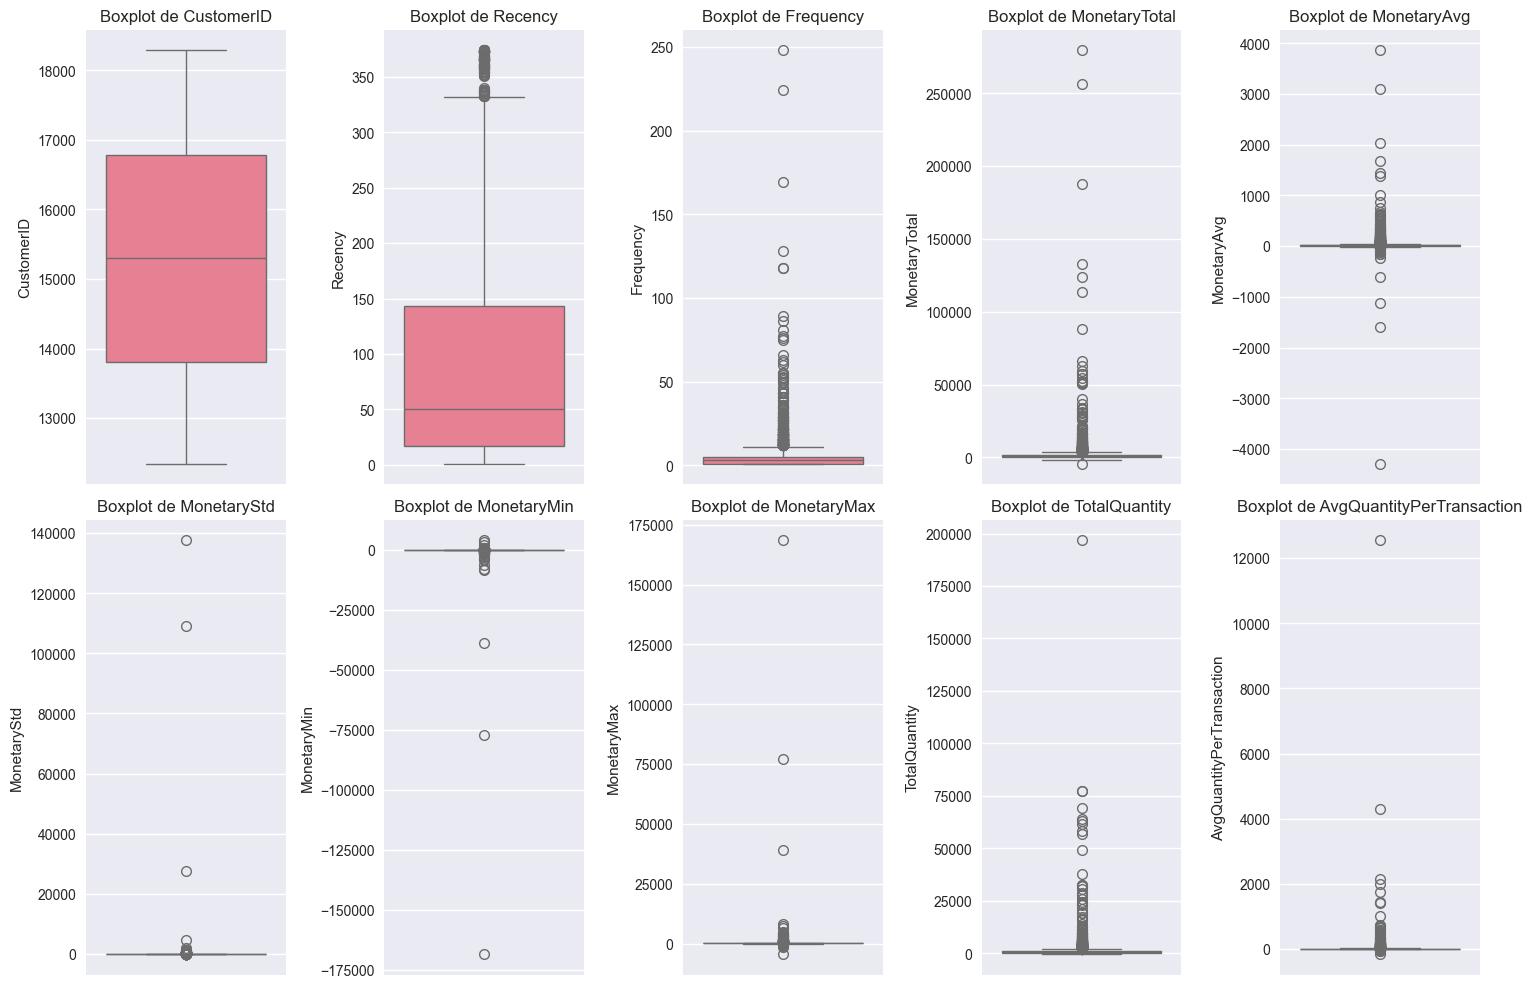

Nombre d'outliers dans Age : 0
Nombre d'outliers dans MonetaryTotal : 423


In [26]:
# Sélection des colonnes numériques
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Boxplots pour détecter les outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols[:10]):  # Limiter à 10 pour lisibilité
    plt.subplot(2, 5, i+1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot de {col}')
plt.tight_layout()
plt.show()

# Fonction pour détecter les outliers via IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Exemple : Détection d'outliers pour 'Age' et 'MonetaryTotal'
for col in ['Age', 'MonetaryTotal']:
    outliers = detect_outliers_iqr(df, col)
    print(f"Nombre d'outliers dans {col} : {len(outliers)}")

### 3. Corrélations

Analysons les corrélations entre les features pour détecter la multicolinéarité.

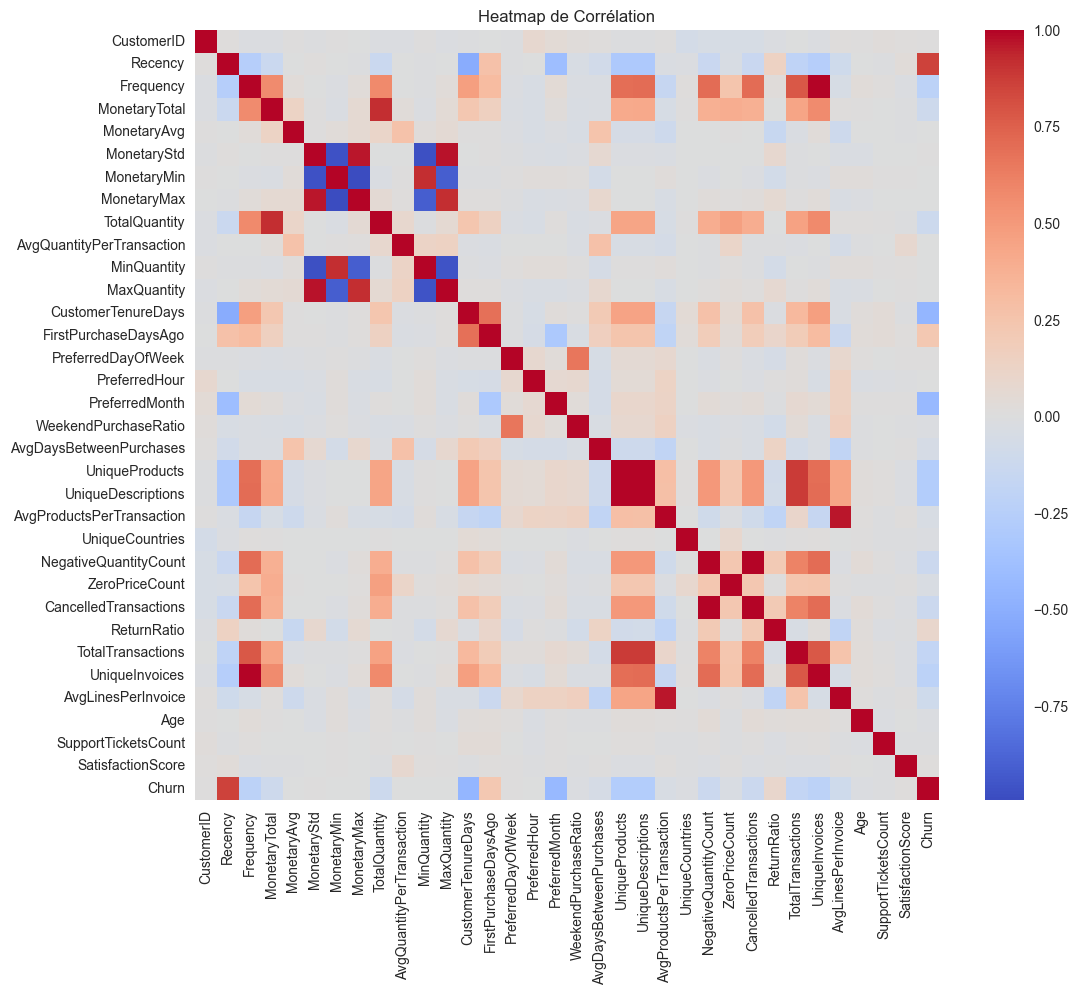

VIF pour les features numériques :
                      feature           VIF
0                  CustomerID  6.850742e+01
1                     Recency  9.048220e+04
2                   Frequency           inf
5                 MonetaryStd  2.161991e+02
6                 MonetaryMin  1.278832e+02
7                 MonetaryMax  1.421209e+02
10                MinQuantity  5.979187e+01
11                MaxQuantity  9.261874e+01
12         CustomerTenureDays  1.778653e+05
13       FirstPurchaseDaysAgo  3.236883e+05
15              PreferredHour  3.091863e+01
19             UniqueProducts  1.382917e+04
20         UniqueDescriptions  1.401397e+04
21  AvgProductsPerTransaction  6.326948e+01
22            UniqueCountries  9.373655e+01
23      NegativeQuantityCount           inf
25      CancelledTransactions           inf
27          TotalTransactions  1.280328e+01
28             UniqueInvoices           inf
29         AvgLinesPerInvoice  7.332013e+01


In [27]:
# Matrice de corrélation
corr_matrix = df[numeric_cols].corr()

# Heatmap de corrélation
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Heatmap de Corrélation')
plt.show()

# Détection de multicolinéarité via VIF (Variance Inflation Factor)
def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["feature"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]
    return vif_data

# Calculer VIF pour les colonnes numériques (attention : peut être lent avec 52 features)
vif_df = calculate_vif(df[numeric_cols].dropna())
print("VIF pour les features numériques :")
print(vif_df[vif_df['VIF'] > 10])  # VIF > 10 indique multicolinéarité

## Correction des Problèmes de Qualité

### 1. Imputation des Valeurs Manquantes

Imputons les valeurs manquantes en utilisant des méthodes appropriées (KNN pour numériques, médiane pour catégorielles).

In [28]:
# Imputation pour colonnes numériques (ex. : Age avec KNN)
knn_imputer = KNNImputer(n_neighbors=5)
df[numeric_cols] = knn_imputer.fit_transform(df[numeric_cols])

# Imputation pour colonnes catégorielles (ex. : Satisfaction avec médiane si numérique, sinon mode)
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)

print("Vérification après imputation :")
print(df.isnull().sum())

Vérification après imputation :
CustomerID                   0
Recency                      0
Frequency                    0
MonetaryTotal                0
MonetaryAvg                  0
MonetaryStd                  0
MonetaryMin                  0
MonetaryMax                  0
TotalQuantity                0
AvgQuantityPerTransaction    0
MinQuantity                  0
MaxQuantity                  0
CustomerTenureDays           0
FirstPurchaseDaysAgo         0
PreferredDayOfWeek           0
PreferredHour                0
PreferredMonth               0
WeekendPurchaseRatio         0
AvgDaysBetweenPurchases      0
UniqueProducts               0
UniqueDescriptions           0
AvgProductsPerTransaction    0
UniqueCountries              0
NegativeQuantityCount        0
ZeroPriceCount               0
CancelledTransactions        0
ReturnRatio                  0
TotalTransactions            0
UniqueInvoices               0
AvgLinesPerInvoice           0
Age                          0
Registr

### 2. Correction des Valeurs Aberrantes

Corrigeons les outliers en les remplaçant par des valeurs limites (winsorizing) ou en les supprimant si nécessaire.

In [29]:
print("Noms des colonnes dans le dataset :")
print(df.columns.tolist())

Noms des colonnes dans le dataset :
['CustomerID', 'Recency', 'Frequency', 'MonetaryTotal', 'MonetaryAvg', 'MonetaryStd', 'MonetaryMin', 'MonetaryMax', 'TotalQuantity', 'AvgQuantityPerTransaction', 'MinQuantity', 'MaxQuantity', 'CustomerTenureDays', 'FirstPurchaseDaysAgo', 'PreferredDayOfWeek', 'PreferredHour', 'PreferredMonth', 'WeekendPurchaseRatio', 'AvgDaysBetweenPurchases', 'UniqueProducts', 'UniqueDescriptions', 'AvgProductsPerTransaction', 'UniqueCountries', 'NegativeQuantityCount', 'ZeroPriceCount', 'CancelledTransactions', 'ReturnRatio', 'TotalTransactions', 'UniqueInvoices', 'AvgLinesPerInvoice', 'Age', 'RegistrationDate', 'NewsletterSubscribed', 'LastLoginIP', 'SupportTicketsCount', 'SatisfactionScore', 'RFMSegment', 'AgeCategory', 'SpendingCategory', 'CustomerType', 'FavoriteSeason', 'PreferredTimeOfDay', 'Region', 'LoyaltyLevel', 'ChurnRiskCategory', 'WeekendPreference', 'BasketSizeCategory', 'ProductDiversity', 'Gender', 'AccountStatus', 'Country', 'Churn']


In [30]:
# Fonction pour winsorizing (remplacer outliers par percentiles)
def winsorize(data, column, lower_percentile=0.05, upper_percentile=0.95):
    lower_bound = data[column].quantile(lower_percentile)
    upper_bound = data[column].quantile(upper_percentile)
    data[column] = np.where(data[column] < lower_bound, lower_bound, data[column])
    data[column] = np.where(data[column] > upper_bound, upper_bound, data[column])
    return data

# Appliquer winsorizing à des colonnes sensibles (ex. : SupportTickets, Satisfaction)
for col in ['SupportTicketsCount', 'SatisfactionScore']:
    df = winsorize(df, col)

print("Statistiques après correction des outliers :")
print(df[['SupportTicketsCount', 'SatisfactionScore']].describe())

Statistiques après correction des outliers :
       SupportTicketsCount  SatisfactionScore
count          4372.000000        4372.000000
mean              1.986505           2.903477
std               1.397468           1.570232
min               0.000000           0.000000
25%               1.000000           2.000000
50%               2.000000           3.000000
75%               3.000000           4.000000
max               5.000000           5.000000


### 3. Suppression de Features Inutiles

Supprimons les features constantes ou avec trop de multicolinéarité.

In [31]:
# Supprimer les colonnes constantes (variance nulle)
constant_cols = [col for col in df.columns if df[col].nunique() == 1]
df.drop(columns=constant_cols, inplace=True)
print(f"Colonnes constantes supprimées : {constant_cols}")

# Supprimer les colonnes avec VIF > 10 (exemple : si multicolinéarité détectée)
high_vif_cols = vif_df[vif_df['VIF'] > 10]['feature'].tolist()
df.drop(columns=high_vif_cols, inplace=True)
print(f"Colonnes avec haute multicolinéarité supprimées : {high_vif_cols}")


Colonnes constantes supprimées : ['NewsletterSubscribed']
Colonnes avec haute multicolinéarité supprimées : ['CustomerID', 'Recency', 'Frequency', 'MonetaryStd', 'MonetaryMin', 'MonetaryMax', 'MinQuantity', 'MaxQuantity', 'CustomerTenureDays', 'FirstPurchaseDaysAgo', 'PreferredHour', 'UniqueProducts', 'UniqueDescriptions', 'AvgProductsPerTransaction', 'UniqueCountries', 'NegativeQuantityCount', 'CancelledTransactions', 'TotalTransactions', 'UniqueInvoices', 'AvgLinesPerInvoice']


In [33]:
# Mettre à jour les listes de colonnes après suppressions
numeric_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = df.select_dtypes(include=['object']).columns
print(f"Colonnes numériques restantes : {numeric_cols.tolist()}")
print(f"Colonnes catégorielles restantes : {categorical_cols.tolist()}")

Colonnes numériques restantes : ['MonetaryTotal', 'MonetaryAvg', 'TotalQuantity', 'AvgQuantityPerTransaction', 'PreferredDayOfWeek', 'PreferredMonth', 'WeekendPurchaseRatio', 'AvgDaysBetweenPurchases', 'ZeroPriceCount', 'ReturnRatio', 'Age', 'SupportTicketsCount', 'SatisfactionScore', 'Churn']
Colonnes catégorielles restantes : ['RegistrationDate', 'LastLoginIP', 'RFMSegment', 'AgeCategory', 'SpendingCategory', 'CustomerType', 'FavoriteSeason', 'PreferredTimeOfDay', 'Region', 'LoyaltyLevel', 'ChurnRiskCategory', 'WeekendPreference', 'BasketSizeCategory', 'ProductDiversity', 'Gender', 'AccountStatus', 'Country']


## Exploration et Préparation des Données

### 1. Analyse Exploratoire Supplémentaire

Visualisons les distributions et relations clés.

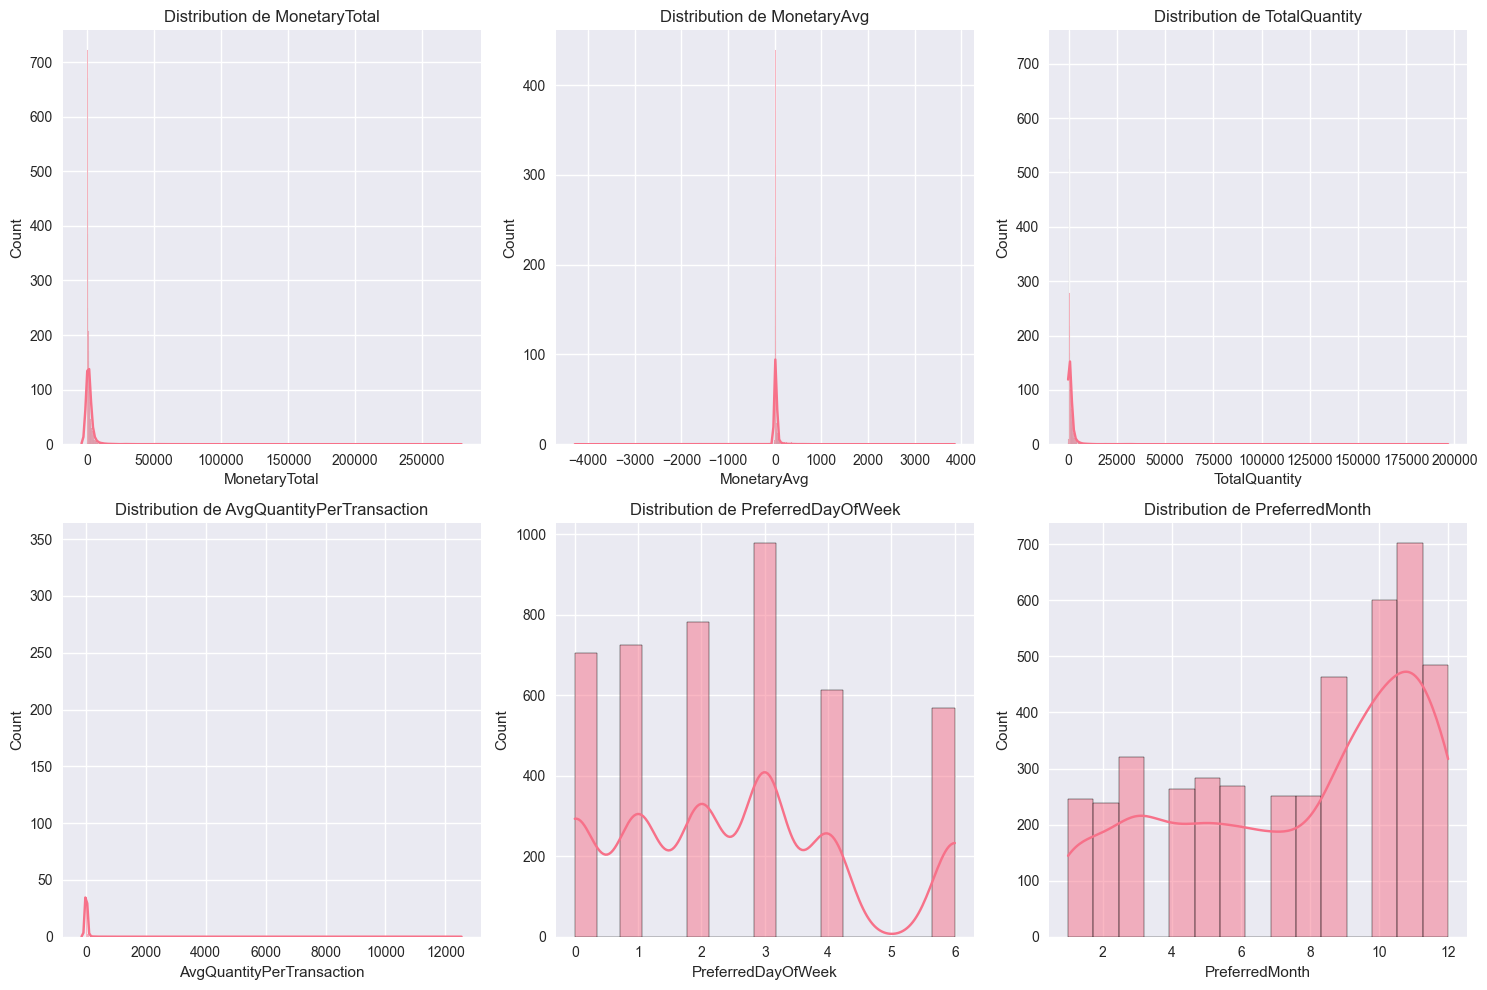

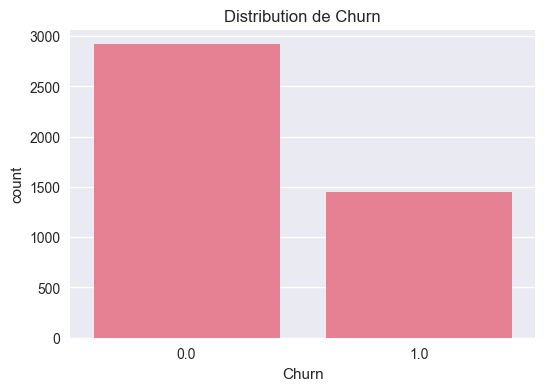

In [34]:
# Distributions des variables numériques
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols[:6]):
    plt.subplot(2, 3, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution de {col}')
plt.tight_layout()
plt.show()

# Analyse de la variable cible (ex. : Churn si présente)
if 'Churn' in df.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(x='Churn', data=df)
    plt.title('Distribution de Churn')
    plt.show()

### 2. Encodage des Variables Catégorielles

Préparons l'encodage pour les phases suivantes.

In [ ]:
# One-Hot Encoding pour les catégorielles (exemple)
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_cols = pd.DataFrame(encoder.fit_transform(df[categorical_cols]))
encoded_cols.columns = encoder.get_feature_names_out(categorical_cols)
df = pd.concat([df.drop(columns=categorical_cols), encoded_cols], axis=1)

print("Dataset après encodage :")
print(df.head())

### 3. Normalisation et Split Train/Test

Normalisons et préparons le split (attention : appliquer après split pour éviter data leakage).

In [ ]:
# Split train/test (stratifié si Churn existe)
if 'Churn' in df.columns:
    X = df.drop('Churn', axis=1)
    y = df['Churn']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
else:
    X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

# Normalisation sur train
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

print("Taille des ensembles :")
print(f"Train : {X_train_scaled.shape}, Test : {X_test_scaled.shape}")

### 4. Réduction de Dimension (ACP)

Appliquons une ACP pour visualisation.

In [ ]:
# ACP sur les données d'entraînement
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

# Visualisation
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], alpha=0.5)
plt.title('ACP - 2 Composantes Principales')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

print(f"Variance expliquée par les 2 premières composantes : {pca.explained_variance_ratio_}")

## Sauvegarde des Données Préparées

Sauvegardons les données nettoyées pour les phases suivantes.

In [ ]:
# Sauvegarde dans data/processed/
df.to_csv('../data/processed/cleaned_data.csv', index=False)
X_train_scaled.to_csv('../data/train_test/X_train.csv', index=False)
X_test_scaled.to_csv('../data/train_test/X_test.csv', index=False)
if 'Churn' in df.columns:
    y_train.to_csv('../data/train_test/y_train.csv', index=False)
    y_test.to_csv('../data/train_test/y_test.csv', index=False)

print("Données sauvegardées avec succès !")

## Conclusion

Ce notebook a permis d'explorer et de préparer le dataset en correctant les problèmes de qualité (valeurs manquantes, aberrantes, multicolinéarité) et en préparant les données pour les étapes de modélisation. Les données nettoyées sont maintenant prêtes pour le preprocessing avancé et la modélisation dans les notebooks suivants.